# Project 2, part c - logistic regression

## Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(12) # for replication purposes

## (Stochastic) Gradient Descent

In [20]:
####
# This function does one sgd epoch.
# The assumptions are that the is some big data set and corresponding cost function floating around
# They should come from the function calling one_epoch_sgd.
#
# N is the number of data points, i.e. the number of times we will update our guess;
# curr_guess is the current guess at a minimum (to be updated);
# learning_rate is the size of the steps we take. 
#
# diff is a function that takes an index i and a vector theta0, 
# it computes the gradient of the cost function at the point theta0,
# when the only data used is the i'th row of the whole data set.

def one_epoch_sgd(N, curr_guess, diff, learning_rate) :
    # make a list of 0,1,2, ... N-1,
    # shuffled around
    shuffled_indices = np.random.permutation(N)
    for i in shuffled_indices :
        curr_guess = curr_guess - learning_rate * diff(i, curr_guess)
    
    return curr_guess

####
# This function uses sgd to find the minimum of a cost function. 
# The assumption is that the cost function breaks into a sum 
# C(theta) = sum_{i=1}^N c(theta; X[i], y[i])
#
# dsummand should compute the gradient of c at a given theta0, 
# if it is also given a row of data and a coresponding y.
#
# We are given the data X, ys;
# the number of epochs and the learning rate. 

def sgd_min(X, ys, dsummand, epochs, learning_rate) :
    N = len(ys) # number of data points 
    p = X.shape[1] # number of columns in X, i.e. number of parameters
    theta = np.random.randn(p,1) # theta is initialized to random values
    # we turn dsummand into a function that takes a row numbers ks, and a theta0,
    # it then evaluteas the dsummand at theta0 when the data is the k'th row of X
    # and the k'th entry of y.
    diff_single_row = (lambda k, theta0 : dsummand(X[[k],:], ys[k], theta0))
    
    # loop over the epochs and for each one do a single epoch step
    for i in range(epochs) :
        theta = one_epoch_sgd(N, theta, diff_single_row, learning_rate)
        
    return theta


####
# This is the same as one_ecpoch_sgd but it uses mini batches
# It must be the case that batch_size divides N
def one_epoch_batch(N, curr_guess, diff, learning_rate, batch_size = 1) :
    m = int(N/batch_size) # number of batches
    # 0,1,2, ... N-1, shuffled around
    # in the shape of a matrix with m columns
    # each row consitutes a batch
    batches = np.random.permutation(N).reshape((-1, m))
    for batch in batches :
        # first compute the gradient at each index in the batch
        # hstack joins them into one matrix
        grad_matrix = np.hstack([diff(b, curr_guess) for b in batch])
        # avarage the entries of each row 
        grad = np.mean(grad_matrix, axis=1).reshape(-1, 1)
        
        # update guess
        curr_guess = curr_guess - learning_rate * grad
        
    return curr_guess

####
# Now we have an sgd_min using batches
# bs, the batch size, mush divide the number of data points
def sgd_bathces_min(X, ys, dsummand, epochs, learning_rate, bs = 1) :
    N = len(ys) # number of data points 
    p = X.shape[1] # number of columns in X, i.e. number of parameters
    theta = np.random.randn(p,1) # theta is initialized to random values
    # we turn dsummand into a function that takes a row numbers k, and a theta0,
    # it then evaluteas the dsummand at theta0 when the data is the k'th row of X
    # and the k'th entry of y.
    #print(X[1])
    #print(X[[1],:])
    diff_single_row = (lambda k, theta0 : dsummand(X[k].reshape(-1,p), ys[k], theta0))
    
    # loop over the epochs and for each one do a single epoch step
    for i in range(epochs) :
        theta = one_epoch_batch(N, theta, diff_single_row, learning_rate, batch_size = bs)
        
    return theta


####
# xs is a row vector
# y is the "true" values of that row of parameters
# b0 is a column vector
# This function returns the gradient of the function (xs @ beta - y)**2 
# evaluated at b0.
# This is to be used for sgd when the cost function is a least squares one
def diff_single_row_square_sum(xs, y, b0) :
    return 2*(xs @ b0 - y)*(xs.T) 


# as above but using cross entropy
def sigmoid(x) : 
    return 1/(1+np.exp(-x))

def diff_single_row_cross_entropy(xs, y, b0) :
    return (sigmoid(xs @ b0) - y)*(xs.T)

def diff_ss_ridge(xs, y, b0, alpha) :
    return 2*(xs @ b0 - y)*(xs.T) + 2*alpha*b0

In [21]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

x = 2*np.random.rand(100,1)
y = 4+3*x+np.random.randn(100,1)

xb = np.c_[np.ones((100,1)), x]
theta_linreg = np.linalg.inv(xb.T.dot(xb)).dot(xb.T).dot(y)
print("Own inversion")
print(theta_linreg)
sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(x,y.ravel())
print("sgdreg from scikit")
print(sgdreg.intercept_, sgdreg.coef_)

print("")

print("")
print("My things")
#print("First without batches")
#print(sgd_min(xb, y, diff_square_sum, 50, 0.1))
print("Then with size 10 batches")
print(sgd_bathces_min(xb, y, diff_single_row_square_sum, 50, 0.1, bs=10))


Own inversion
[[3.51382034]
 [3.20945535]]
sgdreg from scikit
[3.47137684] [3.15033894]


My things
Then with size 10 batches
[[3.44731691]
 [3.11689221]]


In [6]:
class my_logistic_regression :
    
    def __init__(self, epochs = 1000, eta = 0.1) :
        self.theta = 0
        self.epochs = epochs
        self.eta = eta
        
    def fit(self, X, ys, use_batches = False, batches = 10) :
        if use_batches :
            self.theta = sgd_bathces_min(X, ys, diff_single_row_cross_entropy, self.epochs, self.eta, batches)
        else :
            self.theta = sgd_min(X, ys, diff_single_row_cross_entropy, self.epochs, self.eta)
    def soft_predict(self, X) :
        return sigmoid(X @ self.theta)
    
    def predict(self, X) :
        return np.around(sigmoid(X @ self.theta))


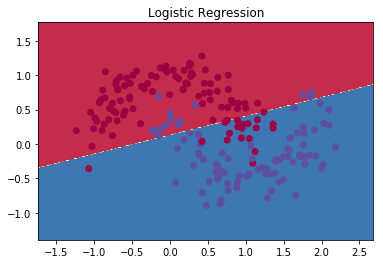

Accuracy: 0.835000


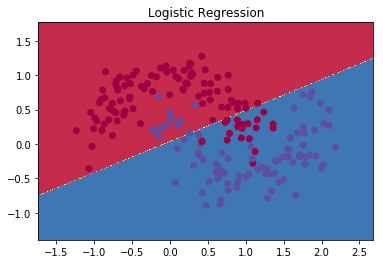

Accuracy: 0.840000

coeffs from sci-kit learn
[0.58869292]
[[ 1.30842946 -4.77834447]]

My coeffs
[[ 0.0806089 ]
 [ 1.28870595]
 [-2.8583731 ]]


In [22]:
def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(1000, noise=0.20)
    return X, y

def visualize(X, y, clf):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary( lambda x: clf.predict(x), X, y)

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Logistic Regression")
    plt.show()
    
def classify(X, y):
    clf = linear_model.LogisticRegressionCV()
    clf.fit(X, y)
    return clf

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# visualize(X, y)
clf = classify(X_train, y_train)
visualize(X_test, y_test, clf)

print("Accuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))

def add_ones(X) :
    return np.hstack((np.ones((X.shape[0], 1)), X))

#### add ones
X_train = add_ones(X_train)
my_logreg = my_logistic_regression(epochs = 100, eta = 0.01)
my_logreg.fit(X_train,y_train, use_batches = True, batches = 40)

pdb = lambda x : my_logreg.predict(x)

# Set min and max values and give it some padding
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole gid
Z =pdb(np.c_[np.ones((xx.shape)).ravel(), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("Logistic Regression")
plt.show()

print("Accuracy: %f" % accuracy_score(y_test, my_logreg.predict(add_ones(X_test))))

print("")
print("coeffs from sci-kit learn")
print(clf.intercept_)
print(clf.coef_)
print("")
print("My coeffs")
print(my_logreg.theta)


## Load in Ising model date

This is basically just copied from the Mehte et al notebooks

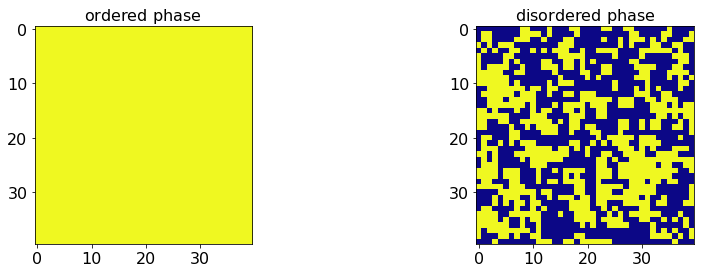

In [6]:
##### prepare training and test data sets
import pickle, os

# path to data directory
path_to_data=os.path.expanduser('~')+'\Documents\GitHub\ml-exercises\Rapport 2\Isingdata\\'

# load data
file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]
# we will ignore the critical temperatures
#X_critical=data[70000:100000,:]
#Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

##### plot a few Ising states

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=2)

axarr[0].imshow(X_ordered[20001].reshape(40,40),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

im=axarr[1].imshow(X_disordered[50001].reshape(40,40),**cmap_args)
axarr[1].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()


In [7]:
print(X_train[1])

[-1  1  1 ... -1 -1 -1]


In [8]:
#### add ones
my_logreg = my_logistic_regression(epochs = 30, eta = 0.01)
my_logreg.fit(add_ones(X_train),Y_train, use_batches = True, batches = 1000)

print("Accuracy: %f" % accuracy_score(Y_test, np.around(my_logreg.predict(add_ones(X_test)))))

#print("")
#print("coeffs from sci-kit learn")
#print(clf.intercept_)
#print(clf.coef_)
print("")
print("My coeffs")
print(my_logreg.theta)


Accuracy: 0.457154

My coeffs
[[ 0.22016448]
 [-0.02741901]
 [-0.01649158]
 ...
 [ 0.02519156]
 [-0.00951686]
 [ 0.01701539]]
